In [1]:
# %load std_libraries.py
# If I make many files here, would be good to do this
import sys
#Indicate operating environment and import core modules
location_input = input("what computer are you on? a = Bens, b = gpucluster, c = other   ")
location_dict = {'a': "C:\\Users\\heine\\github\\expression_broad_data", 'b': "/home/heineike/github/expression_broad_data",'c':'you need to add your location to the location_dict'}
base_dir_rna_seq = location_dict[location_input]
print("rna_seq base directory is " + base_dir_rna_seq)

if sys.path[-1] != base_dir_rna_seq:
    sys.path.append(base_dir_rna_seq)
    print("Added " + base_dir_rna_seq + " to path: " )
    print(sys.path)

import os

print("I am about to import a library")
from core import expression_plots 
from core import io_library 
%load_ext autoreload
%autoreload 2
# %matplotlib 
# plt.ioff()
#%matplotlib inline
%matplotlib notebook

base_dir = os.path.normpath("C:/Users/heine/Google Drive/UCSF/Yeast_colony_drop_seq")
data_processing_dir = os.path.normpath(base_dir + os.sep + "data")
#base_dir + os.sep + os.path.normpath("expression_data") + os.sep

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colorbar as mpl_colorbar
import matplotlib.colors as mpl_colors
#import matplotlib.colormap as cm
#from matplotlib_venn import venn2
import seaborn as sns; sns.set(style="ticks", color_codes=True)
#from sklearn import linear_model
#import pickle
#import subprocess
#import networkx as nx
import scipy.stats as stats
#import statsmodels.graphics.gofplots as stats_graph
import scipy.cluster.hierarchy as sch
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# from Bio import SeqIO
# from Bio import SeqFeature as sf
# from Bio.SeqRecord import SeqRecord
# from Bio.Alphabet import generic_dna
# from Bio.Seq import Seq

# import re

# from collections import Counter
# import scipy.stats as stats
# from itertools import chain
#from itertools import product
#this only works if you are online
online_input = input("are you online? Yes/No")
if online_input == "Yes": 
    import plotly.plotly as py
    import plotly.graph_objs as pygo
    import plotly.tools as pytools
    py.sign_in('heineike02_student','9dMTMZgJMgUP0YX0P5mQ')
    #py.sign_in('heineike02', 'APPjKrtARaN2ZgUYIkqr')
    
# for phylogenetic trees: 
# from ete3 import Tree

#for scraping internet data (e.g. ncbi)
#import requests
#from lxml import etree    #parses xml output

what computer are you on? a = Bens, b = gpucluster, c = other   a
rna_seq base directory is C:\Users\heine\github\expression_broad_data
Added C:\Users\heine\github\expression_broad_data to path: 
['', 'C:\\Users\\heine\\Anaconda3\\python36.zip', 'C:\\Users\\heine\\Anaconda3\\DLLs', 'C:\\Users\\heine\\Anaconda3\\lib', 'C:\\Users\\heine\\Anaconda3', 'C:\\Users\\heine\\Anaconda3\\lib\\site-packages', 'C:\\Users\\heine\\Anaconda3\\lib\\site-packages\\Babel-2.5.0-py3.6.egg', 'C:\\Users\\heine\\Anaconda3\\lib\\site-packages\\win32', 'C:\\Users\\heine\\Anaconda3\\lib\\site-packages\\win32\\lib', 'C:\\Users\\heine\\Anaconda3\\lib\\site-packages\\Pythonwin', 'C:\\Users\\heine\\Anaconda3\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\heine\\.ipython', 'C:\\Users\\heine\\github\\expression_broad_data']
I am about to import a library
I am importing io_library
what computer are you on? a = Bens, b = gpucluster, c = other   a
base directory is C:\Users\heine\github\expression_broad_data
data

In [80]:
ARO4_lib_data = pd.read_table(data_processing_dir + os.sep + "out_gene_exon_tagged_2000.dge.txt")
ARO4_lib_data.set_index('GENE', inplace = True)

#Update gene names to current SGD names
ico_seq_synonyms = pd.read_csv(data_processing_dir + os.sep + "ICO_seq_common_name_mismatches.csv")
ico_seq_synonyms_dict = dict(zip(ico_seq_synonyms['input'],ico_seq_synonyms['symbol']))
ARO4_lib_data.rename(index =ico_seq_synonyms_dict, inplace = True)

In [81]:
print("The total number of reads is {}".format(ARO4_lib_data.sum().sum()))

The total number of reads is 6793535


<IPython.core.display.Javascript object>


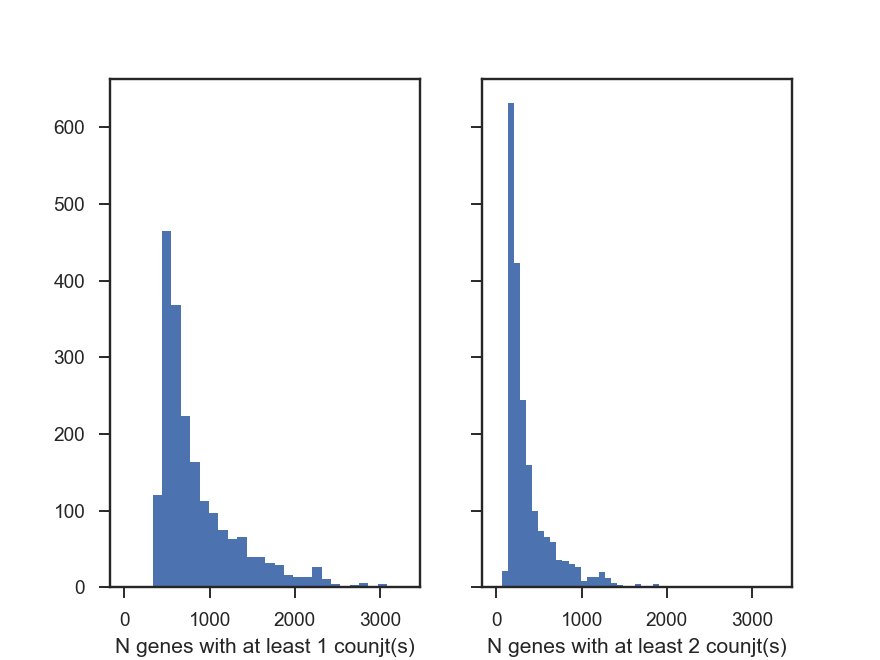

1642
415


In [4]:
#Supplemental Figure 1.  Shows the distribution of counts per colony.  Adjusted in inkscape to show our cutoff. 

fig, axarr = plt.subplots(1,2, sharex = True, sharey = True)

mincounts = 2 
for jj, mincounts in enumerate([1,2]):       #1,2,3,5,10,20
    ax = axarr.flatten()[jj]
    ngenes = []
    for column in ARO4_lib_data.columns:
        ngenes_gt_mincounts = len(ARO4_lib_data[column][ARO4_lib_data[column]>=mincounts])
        ngenes.append(ngenes_gt_mincounts)
    print(len([nn for nn in ngenes if nn>=500 ]))
    ax.hist(ngenes,bins=30)
    ax.set_xlabel("N genes with at least " + str(mincounts) + " count(s)")

    
plt.savefig(os.path.normpath(base_dir + os.sep + "analysis" + os.sep + "20180726_hist_N_genes_raw.svg" ))

In [82]:
#Filter colonies to get ones with more than 500 genes expressing more than one count.  

mincounts = 1 
ngenes = []
thresh_genes = 500
cells_above_thresh = []
for cell in ARO4_lib_data.columns:
    ngenes_gt_mincounts = len(ARO4_lib_data[cell][ARO4_lib_data[cell]>=mincounts])
    ngenes.append(ngenes_gt_mincounts)
    if ngenes_gt_mincounts >=500: 
        cells_above_thresh.append(cell)

ARO4_lib_data_mincount = ARO4_lib_data.loc[:,cells_above_thresh]

#Add a row for total counts and sort descending by that row. 
ARO4_lib_data_mincount_total = ARO4_lib_data_mincount.sum()
ARO4_lib_data_mincount_total.name = 'total_counts'
ARO4_lib_data_mincount = ARO4_lib_data_mincount.append(ARO4_lib_data_mincount_total)
ARO4_lib_data_mincount.sort_values(by='total_counts', axis = 1, ascending = False, inplace=True)

ARO4_lib_data_mincount_genes = ARO4_lib_data_mincount.drop('total_counts')


#Normalize by total counts - this takes a while - I am sure there is a faster way.  
ARO4_lib_data_mincount_genes_norm = ARO4_lib_data_mincount_genes.copy()
ARO4_lib_data_mincount_genes_sum = ARO4_lib_data_mincount_genes.sum()
med = ARO4_lib_data_mincount_genes_sum.median()
for col in ARO4_lib_data_mincount_genes.columns:
    ARO4_lib_data_mincount_genes_norm[col] = ARO4_lib_data_mincount_genes[col]/ARO4_lib_data_mincount_genes_sum[col]*med

# #sort genes by summed expression
# ARO4_high_exp_genes_norm['gene_totals'] = ARO4_high_exp_genes_norm.sum(axis=1)
# ARO4_high_exp_genes_norm.sort_values('gene_totals',ascending=False, inplace=True)
# ARO4_high_exp_genes_norm.drop('gene_totals',axis=1, inplace = True)

pseudocount = med*0.1/ARO4_lib_data_mincount_genes_sum[0]   #I am using 0.1 times 1/the largest number of counts for a pseudocount (multiplied by the median number of counts so all is on the same scale) - thus the pseudocount is 0.1 * the smallest possible value for a single read. 
ARO4_lib_data_mincount_genes_norm = ARO4_lib_data_mincount_genes_norm + pseudocount
ARO4_lib_data_mincount_genes_norm_log10 = np.log10(ARO4_lib_data_mincount_genes_norm)
# ARO4_lib_data_mincount_genes_norm_log10

<IPython.core.display.Javascript object>


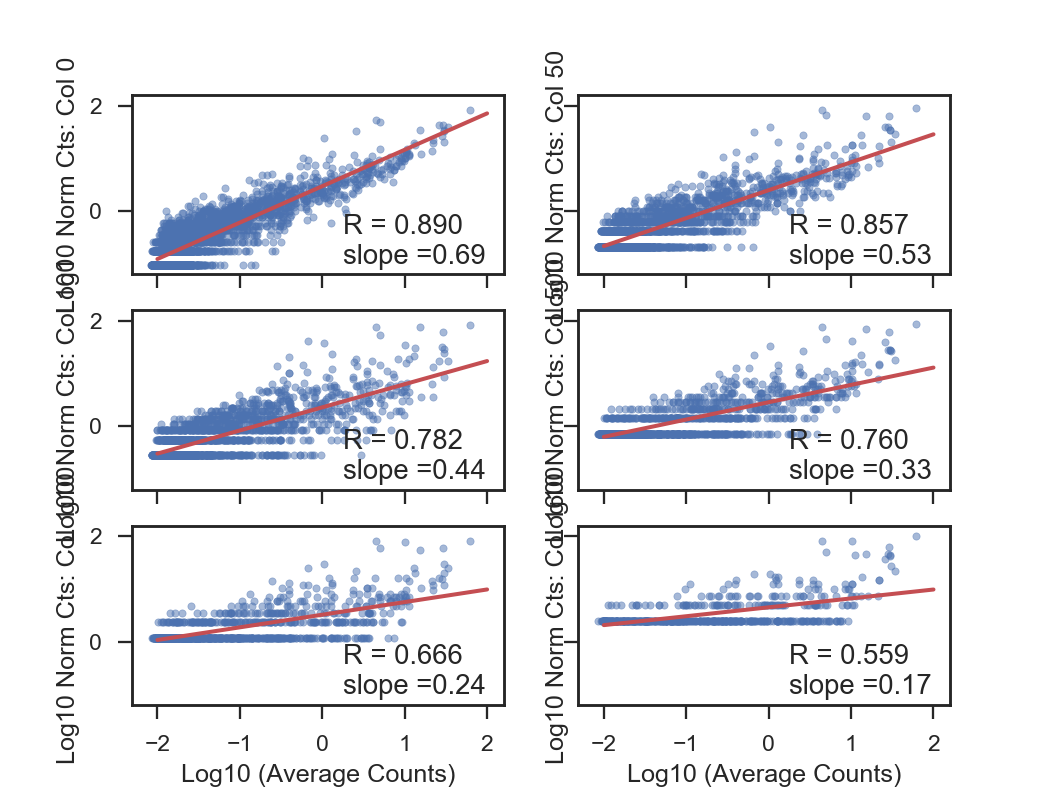

In [5]:
#Supplement 2: Show correlation between colonies for normalized log data.  Would be better if it showed correlation between 
#cells belonging to the same clusters. 

#Filter out 0 genes, plot scatter, superimpose best fit line
fig, axarr = plt.subplots(3,2, sharex = True, sharey = True)

zero_thresh_logspace = -2.0  #the threshold for zero counts in log space based on the pseudocount

columndata_x =  np.array(ARO4_lib_data_mincount_genes_norm_log10.sum(axis=1)/len(ARO4_lib_data_mincount_genes_norm_log10.columns))
for jj, ncol in enumerate([0,50,100,500,1000,1600]):
    ax = axarr.flatten()[jj]
    column_y = ARO4_lib_data_mincount_genes_norm_log10.columns[ncol]
    columndata_y = ARO4_lib_data_mincount_genes_norm_log10[column_y]
    nozero_filter = columndata_y>zero_thresh_logspace
    columndata_x_nozeros = columndata_x[nozero_filter]
    columndata_y_nozeros = columndata_y[nozero_filter]
    ax.scatter(columndata_x_nozeros, columndata_y_nozeros, s = 10, alpha=0.5)
    slope, intercept, r_value, p_value, std_err = stats.linregress(columndata_x_nozeros,columndata_y_nozeros)
    line_xvals = np.linspace(-2.0,2.0, num=4)
    line_yvals = intercept + slope*line_xvals
    ax.plot(line_xvals, line_yvals, 'r')
    ax.set_ylabel("Log10 Norm Cts: Col " + str(ncol))
    ax.text(0.25,-1, "R = {:.3f}\nslope ={:.2f}".format(r_value, slope))
    if jj in [4,5]:
        ax.set_xlabel("Log10 (Average Counts)")
    #print("Column number {} \n Slope = {:.2f}, Intercept = {:.3f}, rvalue = {:.3f}, p_value = {}, std_err = {:.3f}".format(ncol, slope, intercept, r_value, p_value, std_err))


<IPython.core.display.Javascript object>


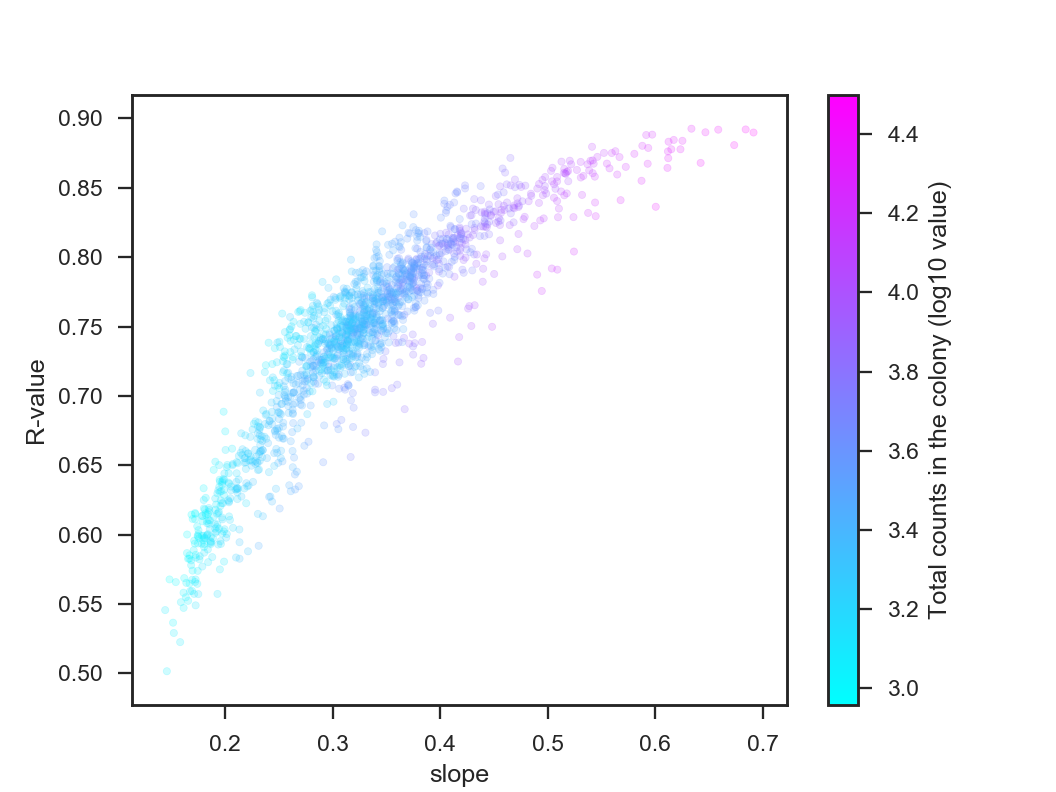

In [6]:
#Supplement - show R values for all cells v.s. the average. 

#Plot all R values against one another. Log Normalized data


columndata_x =  np.array(ARO4_lib_data_mincount_genes_norm_log10.sum(axis=1)/len(ARO4_lib_data_mincount_genes_norm_log10.columns))



fig, ax = plt.subplots()

r_values = []
slopes = []
intercepts = []
for col in ARO4_lib_data_mincount_genes_norm_log10.columns: 
    columndata_y = ARO4_lib_data_mincount_genes_norm_log10[col]
    nozero_filter = columndata_y>zero_thresh_logspace
    columndata_x_nozeros = columndata_x[nozero_filter]
    columndata_y_nozeros = columndata_y[nozero_filter]
    slope, intercept, r_value, p_value, std_err = stats.linregress(columndata_x_nozeros,columndata_y_nozeros)
    r_values.append(r_value)
    slopes.append(slope)
    intercepts.append(intercept)

colordata = np.log10(ARO4_lib_data_mincount.loc['total_counts',:])
#colordata = ARO4_lib_data_mincount.loc['total_counts',:]

ax.scatter(slopes, r_values, c=colordata, cmap = "cool", alpha = 0.2, s = 10)
ax.set_xlabel("slope")
ax.set_ylabel("R-value")


normalize = mpl_colors.Normalize(vmin=min(colordata), vmax=max(colordata))
#normalize = mpl_colors.LogNorm(vmin=min(colordata), vmax=max(colordata))

#ax1.set_xlim([-0.001, 0.0055])
# ax2 = axarr[0,1]
# ax2.scatter(intercepts, r_values, c = colordata, alpha = 0.2, s = 10)
# ax2.set_xlim([-0.08, 0.08])

cax, _ = mpl_colorbar.make_axes(ax)
cbar = mpl_colorbar.ColorbarBase(cax,cmap = 'cool', norm = normalize)
cbar.set_label("Total counts in the colony (log10 value)")


Here we see a clear relationship between R value (and slope) with the total count for the colony.  It seems that in the lower count colonies, the number of gene with small discrete counts is bringing the correlation with the average count data down.  


In [83]:
#Threshold for picking the most highly expressed genes: 
# 1) Genes that have at least N=3 counts in one of the smallest M=300 colonies (as determined by total number of reads)

M = 300
lowcount_thresh = 3
ARO4_high_exp_genes = ARO4_lib_data_mincount_genes[ARO4_lib_data_mincount_genes.iloc[:, -M:].max(axis = 1)>=lowcount_thresh]


<IPython.core.display.Javascript object>


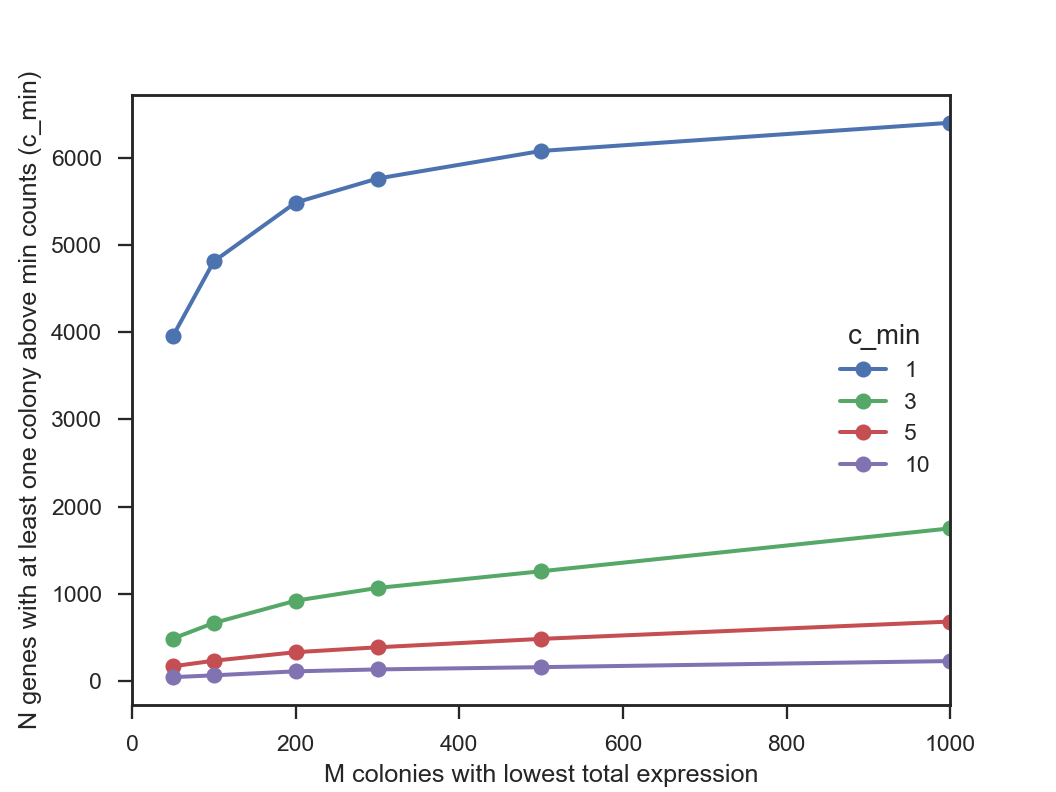

In [8]:
#Get a sense of how many genes we keep as we vary M and the lowcount threshold.  

fig, ax = plt.subplots()

M_vals = [50, 100, 200, 300, 500, 1000]
lowcount_threshs = [1,3,5,10]

N_genes_by_thresh = {}
for lowcount_thresh in lowcount_threshs: 
    N_genes_by_M = []
    for M in M_vals: 
        N_genes_by_M.append(sum(ARO4_lib_data_mincount_genes.iloc[:, -M:].max(axis = 1)>=lowcount_thresh))
    N_genes_by_thresh[lowcount_thresh] = N_genes_by_M

N_genes_by_thresh_df = pd.DataFrame(N_genes_by_thresh, index = M_vals)
N_genes_by_thresh_df.plot(marker = 'o', ax = ax)
ax.set_xlim(0,1000)
ax.set_xlabel("M colonies with lowest total expression")
ax.set_ylabel("N genes with at least one colony above min counts (c_min)")
ax.legend(title = "c_min")

plt.savefig(os.path.normpath(base_dir + os.sep + "analysis" + os.sep + "20180730_lowcount_thresh.svg" ))
        

In [84]:
#Normalize by total counts 
ARO4_high_exp_genes_norm = ARO4_high_exp_genes.copy()
ARO4_high_exp_genes_sum = ARO4_high_exp_genes.sum()
med = ARO4_high_exp_genes_sum.median()
for col in ARO4_high_exp_genes.columns:
    ARO4_high_exp_genes_norm[col] = ARO4_high_exp_genes[col]/ARO4_high_exp_genes_sum[col]*med

#sort genes by summed expression
ARO4_high_exp_genes_norm['gene_totals'] = ARO4_high_exp_genes_norm.sum(axis=1)
ARO4_high_exp_genes_norm.sort_values('gene_totals',ascending=False, inplace=True)
ARO4_high_exp_genes_norm.drop('gene_totals',axis=1, inplace = True)

pseudocount = 0.1/ARO4_high_exp_genes_sum[0]*med   #I am using 0.1 times 1/the largest number of counts for a pseudocount (multiplied by the median number of counts so all is on the same scale) - thus the pseudocount is 0.1 * the smallest possible value for a single read. 
ARO4_high_exp_genes_norm = ARO4_high_exp_genes_norm + pseudocount
ARO4_high_exp_genes_norm_log10 = np.log10(ARO4_high_exp_genes_norm)





<IPython.core.display.Javascript object>


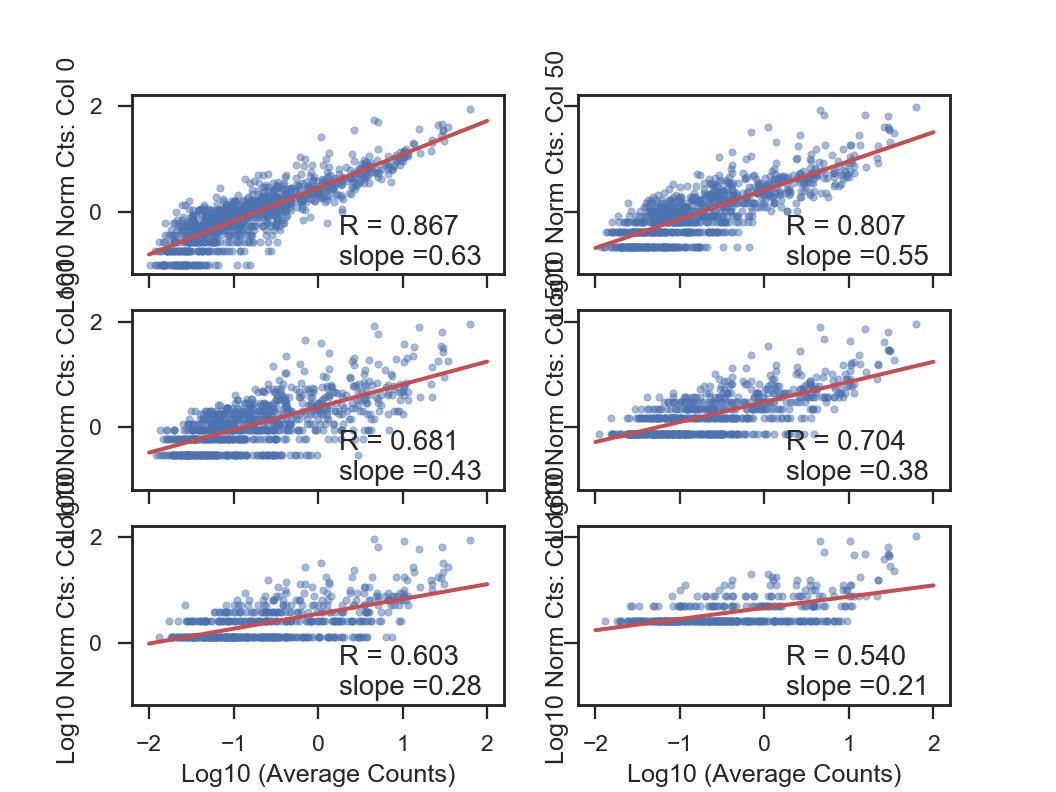

In [10]:
fig, axarr = plt.subplots(3,2, sharex = True, sharey = True)

zero_thresh_logspace = -2.0
columndata_x =  ARO4_high_exp_genes_norm_log10.sum(axis=1)/len(ARO4_high_exp_genes_norm_log10.columns)
for jj, ncol in enumerate([0,50,100,500,1000,1600]):
    ax = axarr.flatten()[jj]
    column_y = ARO4_high_exp_genes_norm_log10.columns[ncol]
    columndata_y = ARO4_high_exp_genes_norm_log10[column_y]
    nozero_filter = columndata_y>zero_thresh_logspace
    columndata_x_nozeros = columndata_x[nozero_filter]
    columndata_y_nozeros = columndata_y[nozero_filter]
    ax.scatter(columndata_x_nozeros, columndata_y_nozeros, s = 10, alpha=0.5)
    slope, intercept, r_value, p_value, std_err = stats.linregress(columndata_x_nozeros,columndata_y_nozeros)
    line_xvals = np.linspace(-2.0,2.0, num=4)
    line_yvals = intercept + slope*line_xvals
    ax.plot(line_xvals, line_yvals, 'r')
    ax.set_ylabel("Log10 Norm Cts: Col " + str(ncol))
    ax.text(0.25,-1, "R = {:.3f}\nslope ={:.2f}".format(r_value, slope))
    if jj in [4,5]:
        ax.set_xlabel("Log10 (Average Counts)")
        

<IPython.core.display.Javascript object>


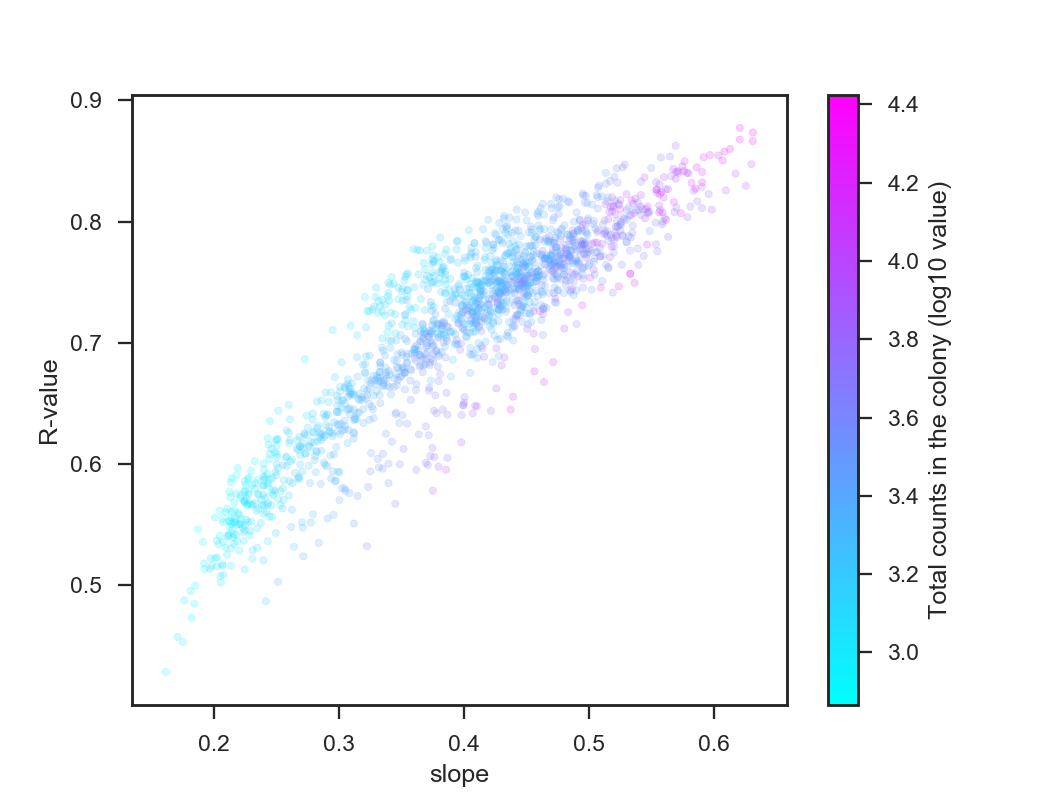

In [11]:
#Plot all R values against one another. 

columndata_x =  ARO4_high_exp_genes_norm_log10.sum(axis=1)/len(ARO4_high_exp_genes_norm_log10.columns)


# for col in ARO4_lib_data_mincount_genes_norm_log10.columns: 
#     columndata_y = ARO4_lib_data_mincount_genes_norm_log10[col]
#     nozero_filter = columndata_y>zero_thresh_logspace
#     columndata_x_nozeros = columndata_x[nozero_filter]
#     columndata_y_nozeros = columndata_y[nozero_filter]
#     slope, intercept, r_value, p_value, std_err = stats.linregress(columndata_x_nozeros,columndata_y_nozeros)



fig, ax = plt.subplots()

r_values = []
slopes = []
intercepts = []
for col in ARO4_high_exp_genes_norm_log10.columns: 
    columndata_y = ARO4_high_exp_genes_norm_log10[col]
    nozero_filter = columndata_y>zero_thresh_logspace
    columndata_x_nozeros = columndata_x[nozero_filter]
    columndata_y_nozeros = columndata_y[nozero_filter]
    slope, intercept, r_value, p_value, std_err = stats.linregress(columndata_x_nozeros,columndata_y_nozeros)
    r_values.append(r_value)
    slopes.append(slope)
    intercepts.append(intercept)

colordata = np.log10(ARO4_high_exp_genes.sum())
#colordata = ARO4_lib_data_mincount.loc['total_counts',:]

ax.scatter(slopes, r_values, c=colordata, cmap = "cool", alpha = 0.2, s = 10)
ax.set_xlabel("slope")
ax.set_ylabel("R-value")


normalize = mpl_colors.Normalize(vmin=min(colordata), vmax=max(colordata))
#normalize = mpl_colors.LogNorm(vmin=min(colordata), vmax=max(colordata))

#ax1.set_xlim([-0.001, 0.0055])
# ax2 = axarr[0,1]
# ax2.scatter(intercepts, r_values, c = colordata, alpha = 0.2, s = 10)
# ax2.set_xlim([-0.08, 0.08])

cax, _ = mpl_colorbar.make_axes(ax)
cbar = mpl_colorbar.ColorbarBase(cax,cmap = 'cool', norm = normalize)
cbar.set_label("Total counts in the colony (log10 value)")

Here are the sample numbers for the various replicates: 
SC_AS_noNMPP1_YPD_t40_rep1	7027	CAAGCA
SC_AS_yesNMPP1_YPD_t40_rep1	7028	GCTCGA
SC_AS_noNMPP1_YPD_t40_rep2	7035	GTTACC
SC_AS_yesNMPP1_YPD_t40_rep2	7036	CGCAAC
SC_AS_noNMPP1_YPD_t40_rep3	7047	GCATGG
SC_AS_yesNMPP1_YPD_t40_rep3	7048	AATAGC

The following rna is counted in the ICO seq data, but not in my bulk data.  
S.Cer orf for snR11not found
S.Cer orf for snR33not found
S.Cer orf for snR49not found
S.Cer orf for snR8not found
S.Cer orf for snR86not found
S.Cer orf for snR9not found
S.Cer orf for 15S_rRNAnot found
S.Cer orf for 21S_rRNAnot found
S.Cer orf for CRS5not found
S.Cer orf for RUF5-2not found


In [36]:
bulk_data_raw_counts = pd.read_csv(base_dir_rna_seq + os.sep + "expression_data" + os.sep + "20170817_klscpka" + os.sep + "20170817_klscpka_counts_all_SC.csv")
bulk_data_raw_YPD = bulk_data_raw_counts.loc[:,['0','7027','7028','7035','7036','7047','7048']]
bulk_data_raw_YPD.rename(columns = {'0':'sc_genename','7027': 'WT 1', '7035': 'WT 2', '7047':'WT 3', '7028':'NMPP1 1','7036':'NMPP1 2','7048':'NMPP1 3'},inplace='True')
bulk_data_raw_YPD.set_index('sc_genename',inplace=True)

#take out subset of genes that we are analyzing for the ICO seq dataset: 
bulk_data_ARO4_subset = bulk_data_raw_YPD_norm.loc[set(io_library.SC_orf_lookup_by_name(ARO4_high_exp_genes.index)) & set(bulk_data_raw_YPD_norm.index),:]

In [131]:
#Normalize by total counts.  Multiply by the same factor we are using for all the ICO seq data
bulk_data_ARO4_subset_norm = bulk_data_ARO4_subset.copy()
bulk_data_ARO4_subset_sum = bulk_data_ARO4_subset.sum()
med_ico = ARO4_high_exp_genes_sum.median()
med = med_ico #bulk_data_raw_YPD_sum.median()
for col in bulk_data_ARO4_subset.columns:
    bulk_data_ARO4_subset_norm[col] = bulk_data_ARO4_subset[col]/bulk_data_ARO4_subset_sum[col]*med
    
#sort genes by summed expression
# ARO4_high_exp_genes_norm['gene_totals'] = ARO4_high_exp_genes_norm.sum(axis=1)
# ARO4_high_exp_genes_norm.sort_values('gene_totals',ascending=False, inplace=True)
# ARO4_high_exp_genes_norm.drop('gene_totals',axis=1, inplace = True)

pseudocount = 0.1/ARO4_high_exp_genes_sum[0]*med_ico   #I am using 0.1 times 1/the largest number of counts for a pseudocount (multiplied by the median number of counts so all is on the same scale) - thus the pseudocount is 0.1 * the smallest possible value for a single read. 
bulk_data_ARO4_subset_norm = bulk_data_ARO4_subset_norm + pseudocount
bulk_data_ARO4_subset_norm_log10 = np.log10(bulk_data_ARO4_subset_norm)

#make columns for mean for each condition and SC common name
bulk_data_ARO4_subset_norm_log10['SC_common_name'] = io_library.SC_common_name_lookup(bulk_data_ARO4_subset_norm_log10.index)
bulk_data_ARO4_subset_norm_log10['WT mean'] = bulk_data_ARO4_subset_norm_log10.loc[:,['WT 1', 'WT 2', 'WT 3']].mean(axis = 1)
bulk_data_ARO4_subset_norm_log10['WT var'] = bulk_data_ARO4_subset_norm_log10.loc[:,['WT 1', 'WT 2', 'WT 3']].var(axis = 1)
bulk_data_ARO4_subset_norm_log10['NMPP1 mean'] = bulk_data_ARO4_subset_norm_log10.loc[:,['NMPP1 1', 'NMPP1 2', 'NMPP1 3']].mean(axis = 1)
bulk_data_ARO4_subset_norm_log10['NMPP1 var'] = bulk_data_ARO4_subset_norm_log10.loc[:,['NMPP1 1', 'NMPP1 2', 'NMPP1 3']].var(axis = 1)


## Before I just imported the raw data
# #Import Bulk Data and add SC Common name.  Extract columns for YPD data. 
# bulk_data = pd.read_csv(base_dir_rna_seq + os.sep + "expression_data" + os.sep + "20170817_klscpka" + os.sep + "20170817_klscpka_avg_counts_SC.csv")
# bulk_data.rename(columns = {"0":"sc_genename"}, inplace = True) 
# bulk_data['SC_common_name'] = io_library.SC_common_name_lookup(bulk_data["sc_genename"])
# bulk_data_YPD = bulk_data.loc[:,['SC_common_name','AS_noNMPP1_YPD_t40_mean','AS_yesNMPP1_YPD_t40_mean']]

<IPython.core.display.Javascript object>


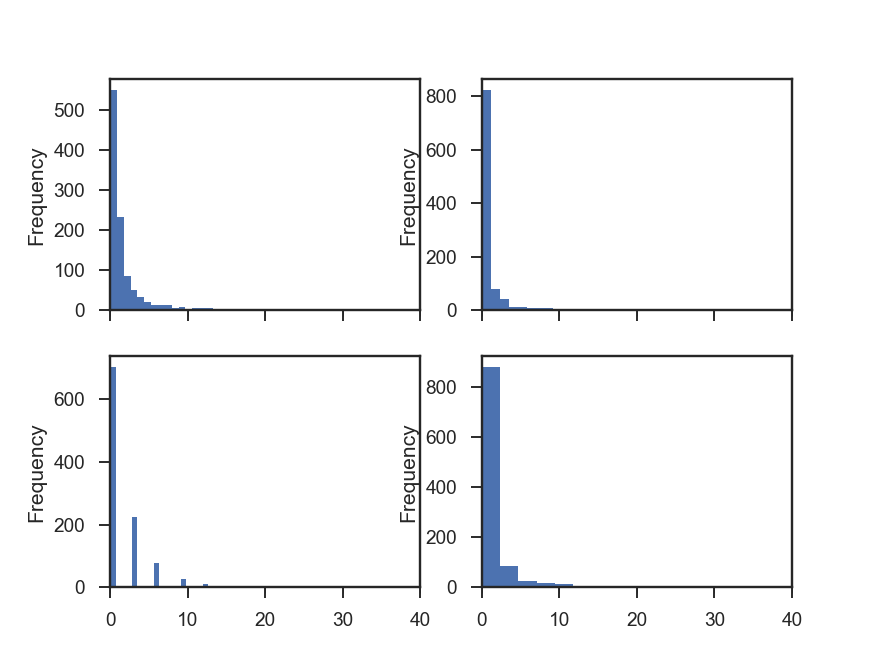

In [205]:
fig, axarr = plt.subplots(2,2, sharex = True)
ARO4_high_exp_genes_norm['AGGTTAGACG'].plot(kind='hist', ax=axarr[0,0], bins = 100, xlim=(0,40) )
ARO4_high_exp_genes_norm['GTTGCAGGTC'].plot(kind='hist', ax=axarr[1,0], bins = 100)
bulk_data_ARO4_subset_norm['WT 1'].plot(kind='hist', ax=axarr[0,1], bins = 100)
bulk_data_ARO4_subset_norm['NMPP1 1'].plot(kind='hist', ax=axarr[1,1], bins = 100)


After subsetting on the genes that we use for ARO4 and multiplying by the same factor following normalization, the bulk data has a similar histogram to an individual colony (looking at first and last individual colony)

In [132]:
#Merge Bulk Data to ARO4 data
bulk_data_to_merge = bulk_data_ARO4_subset_norm_log10.loc[:,['SC_common_name','WT mean', 'NMPP1 mean']]
ARO4_high_exp_genes_norm_log10_merged = ARO4_high_exp_genes_norm_log10.merge(bulk_data_to_merge, left_index = True, right_on = "SC_common_name", how = 'inner')
ARO4_high_exp_genes_norm_log10_merged.set_index('SC_common_name', inplace = True)


<IPython.core.display.Javascript object>


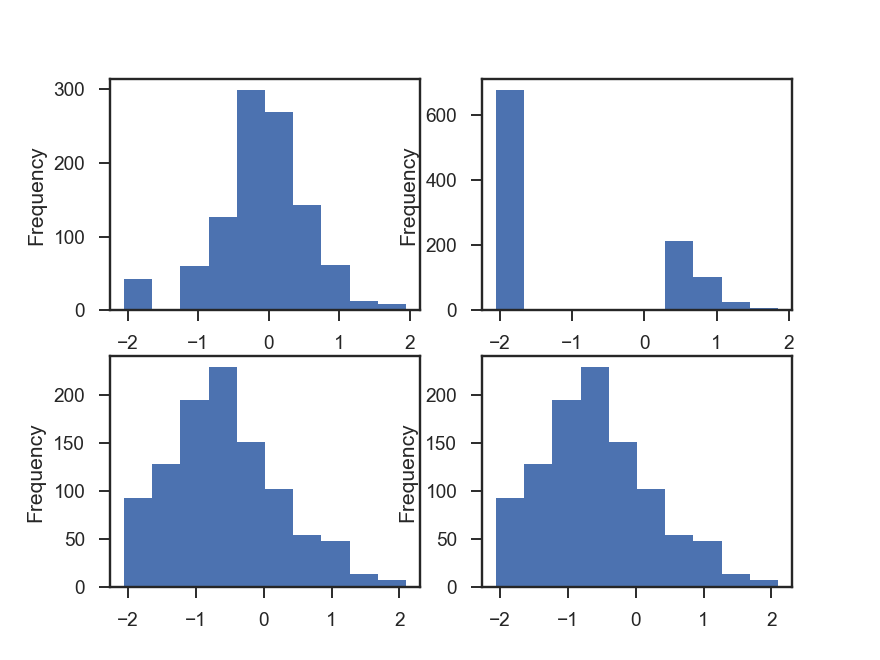

In [133]:
fig, axarr = plt.subplots(2,2)
ARO4_high_exp_genes_norm_log10_merged['AGGTTAGACG'].plot(kind='hist', ax=axarr[0,0])
ARO4_high_exp_genes_norm_log10_merged['GTTGCAGGTC'].plot(kind='hist', ax=axarr[0,1])
ARO4_high_exp_genes_norm_log10_merged['WT mean'].plot(kind='hist', ax=axarr[1,0])
ARO4_high_exp_genes_norm_log10_merged['WT mean'].plot(kind='hist', ax=axarr[1,1])

In [176]:
data = []

conditions = {'WT': "WT mean", 'PKA Inhibited': "NMPP1 mean" }

ARO4_high_exp_genes_norm_log10_avg = ARO4_high_exp_genes_norm_log10_merged.iloc[:,:-2].mean(axis = 1)

for condition, condition_label in conditions.items():
    xvalues = ARO4_high_exp_genes_norm_log10_merged.loc[:,condition_label]
    yvalues = ARO4_high_exp_genes_norm_log10_avg

    trace = pygo.Scatter(
        x = list(xvalues), 
        y =  list(yvalues),
        text = ARO4_high_exp_genes_norm_log10_merged.index,
        mode = 'markers',
        marker = {'opacity': 0.5}, #, 
                  #'color': 'rgba'+str(cmap(NN/10))}, 
        name = condition
    )

    data.append(trace)


    layout = pygo.Layout(
        xaxis= {
            #"range":[-2, 20],
            "title":'Bulk data'
        },
        yaxis= {
            #"range":[-2, 20],
            "title":'Average expression'
        }, 
        width = 500, 
        height = 400
    )


fig = pygo.Figure(data=data, layout = layout)
py.iplot(fig, filename='ico_seq_colony_avg_log_vs_bulk')

The bulk data and the average expression seem correlated - (I should take a look at it by cluster - hypothesis is that the "growing" clusters would correlate much better.  Any gene that has a 0 value gets mapped to -2 in logspace given my pseudocount (rather than -infinity if it had no pseudocount or 0 if the pseudocount was 1 - I feel like a pseudocount of 1 would drown out the signal for any genes with small numbers of counts - and since so many colonies have such small read counts I hesitate to do that.  Putting aside the difference in scale This scatter gives me confidence that we are close to bulk data.  A bit surprising that two high constitutive genes (CCW12 and TDH3) are not so highly expressed in the average ICO seq data. 

<IPython.core.display.Javascript object>


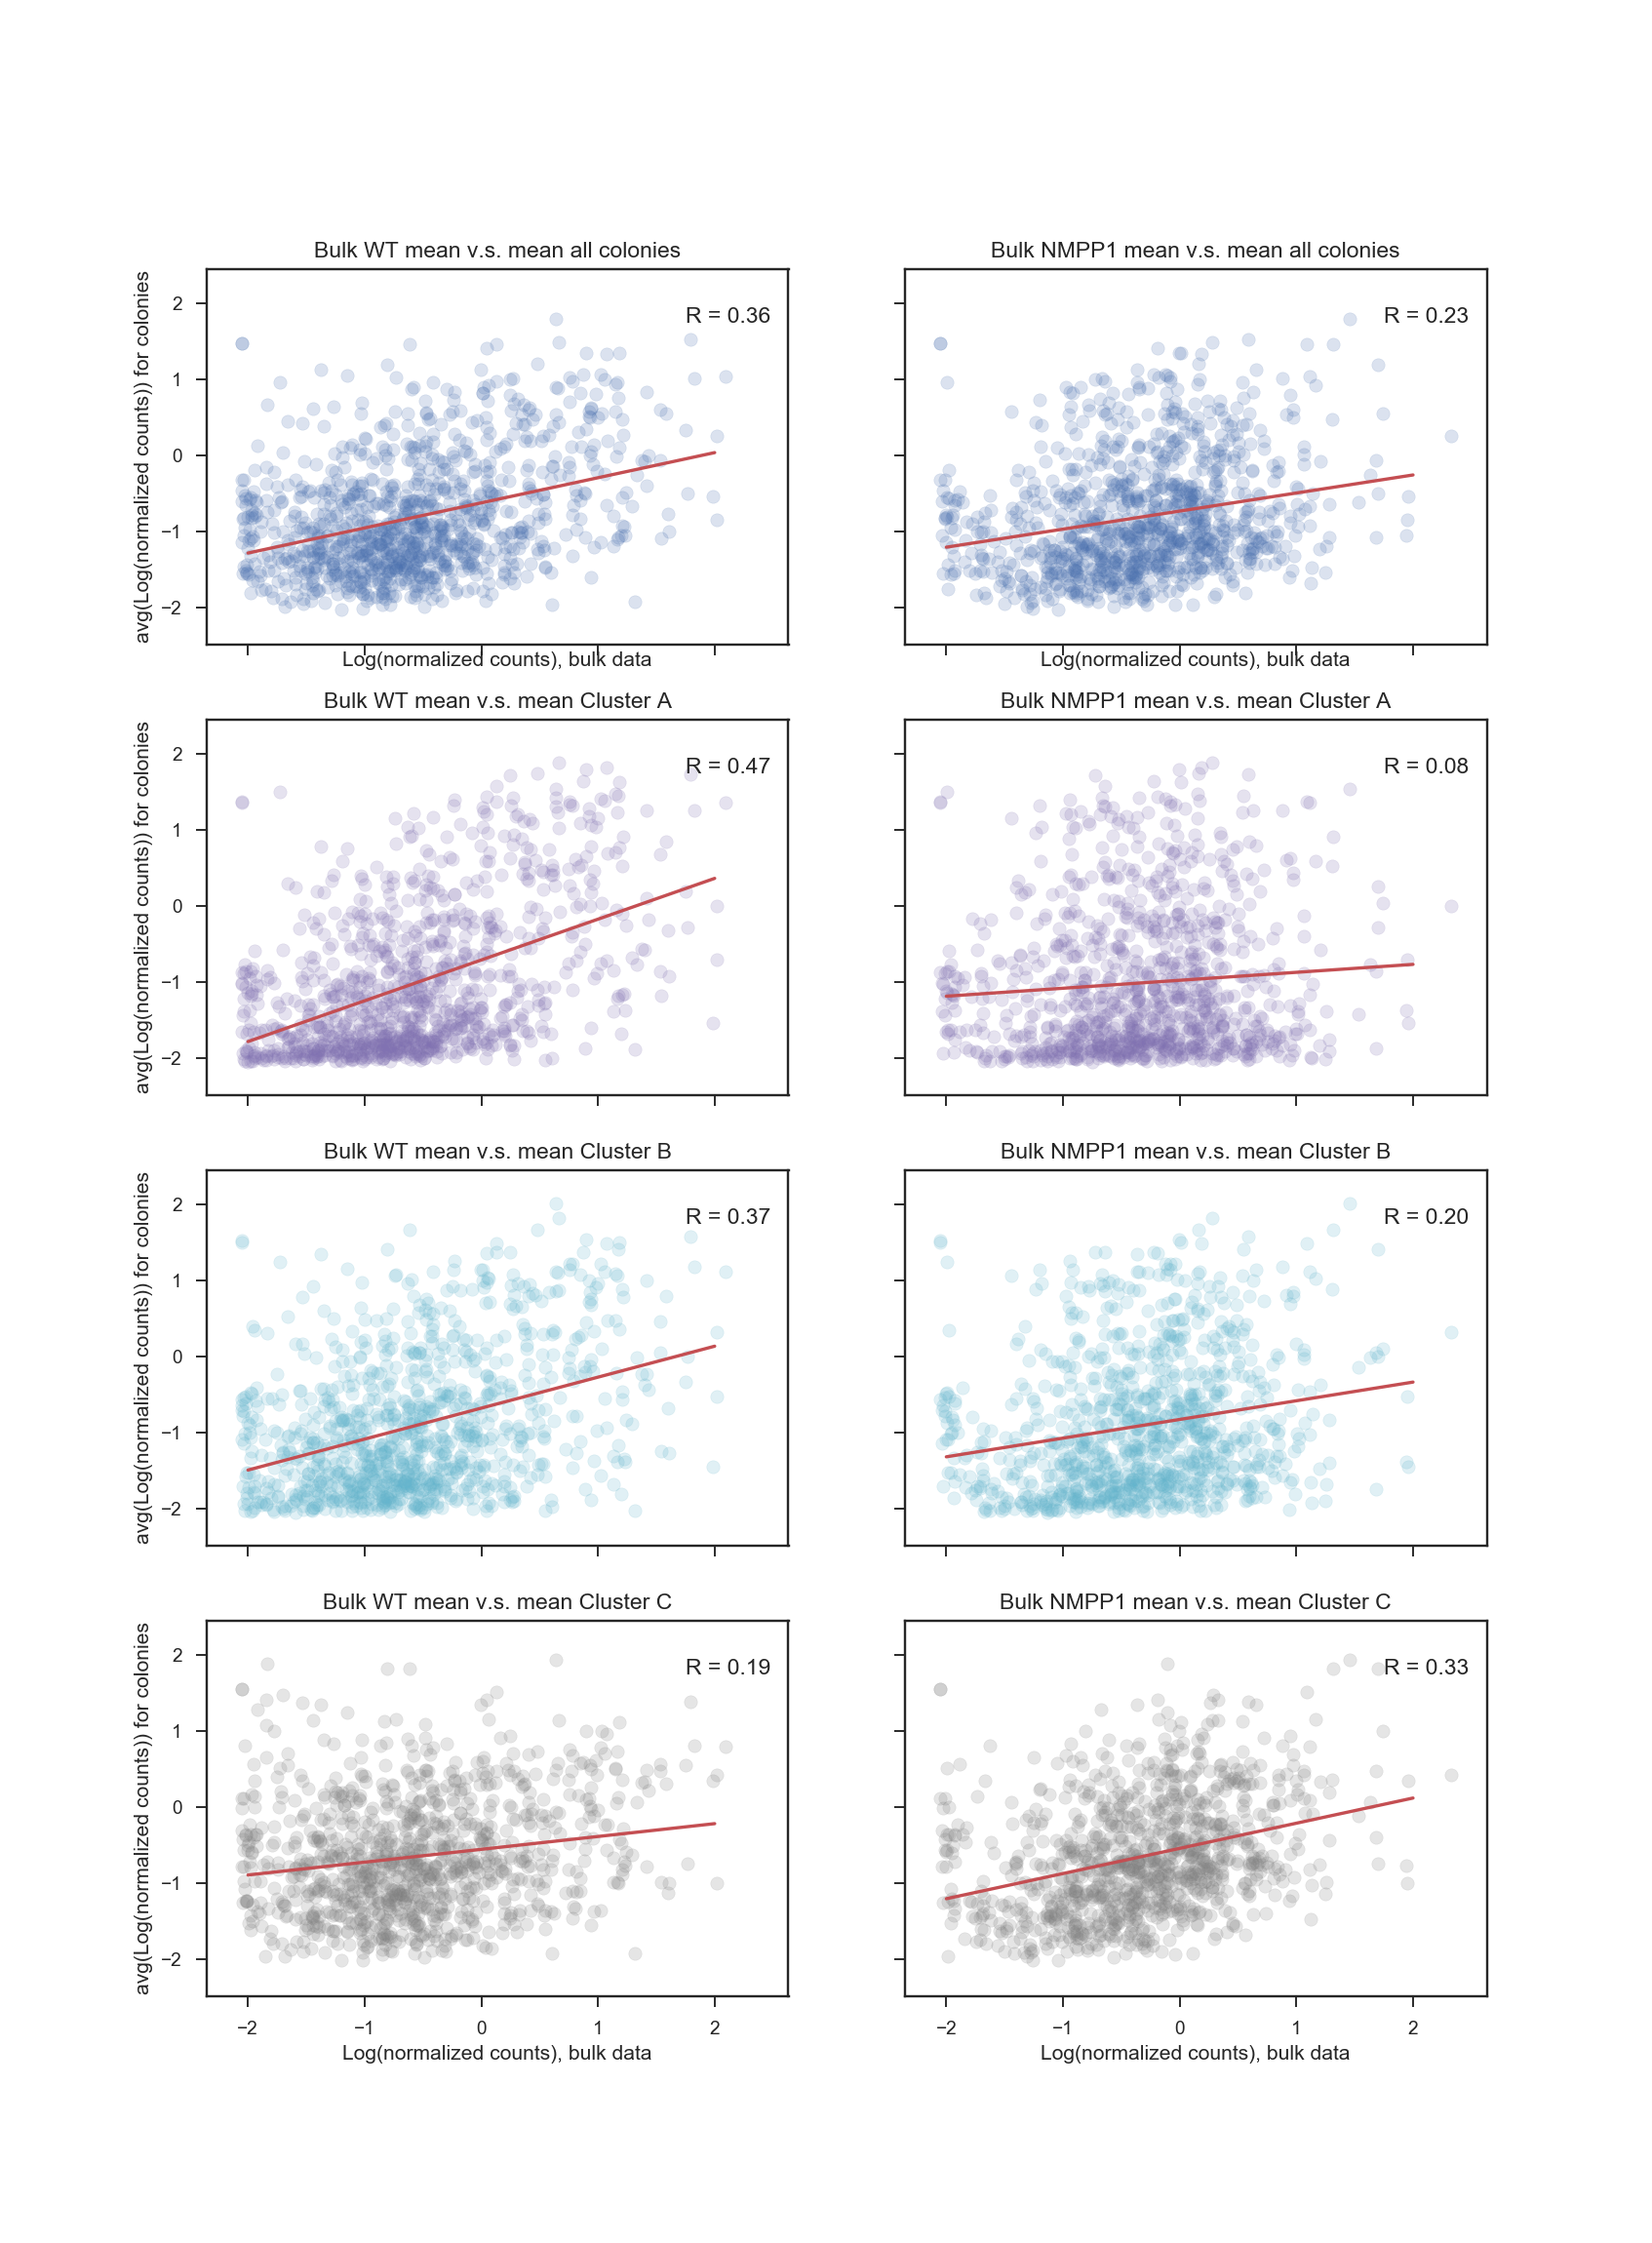

In [228]:
#Plot Bulk Data and Average Expression broken down by WT/PKA inhibition as well as by cluster

fig, axarr = plt.subplots(4,2,sharex = True, sharey = True)

clusters = {'Cluster A': cluster_A, 'Cluster B':cluster_B, 'Cluster C':cluster_C}
colors = {'Cluster A': 'm', 'Cluster B': 'c', 'Cluster C': 'gray'}
conditions = {'WT': "WT mean", 'PKA Inhibited': "NMPP1 mean" }
condition_column = {'WT':0, 'PKA Inhibited': 1}

ARO4_high_exp_genes_norm_log10_avg = ARO4_high_exp_genes_norm_log10_merged.iloc[:,:-2].mean(axis = 1)
yvalues = ARO4_high_exp_genes_norm_log10_avg
for condition, condition_label in conditions.items(): 
    xvalues = ARO4_high_exp_genes_norm_log10_merged.loc[:,condition_label]
    ax = axarr[0,condition_column[condition]]
    ax.scatter(xvalues, yvalues, alpha=0.2)
    ax.set_title('Bulk ' + condition_label + ' v.s. mean all colonies')
    slope, intercept, r_value, p_value, std_err = stats.linregress(xvalues, yvalues)
    line_xvals = np.linspace(-2.0,2.0, num=4)
    line_yvals = intercept + slope*line_xvals
    ax.set_xlabel('Log(normalized counts), bulk data')
    ax.plot(line_xvals, line_yvals, 'r')
    ax.text(1.75, 1.75, 'R = {:.2f}'.format(r_value))
    if condition=='WT':
        ax.set_ylabel('avg(Log(normalized counts)) for colonies')

jj = 1
for cluster_name, cluster in clusters.items():
    yvalues = ARO4_high_exp_genes_norm_log10_merged.loc[:,cluster].mean(axis=1)
    for condition, condition_label in conditions.items(): 
        xvalues = ARO4_high_exp_genes_norm_log10_merged.loc[:,condition_label]
        ax = axarr[jj,condition_column[condition]]
        ax.scatter(xvalues, yvalues, alpha=0.2, color = colors[cluster_name])
        ax.set_title('Bulk ' + condition_label + ' v.s. mean ' + cluster_name )
        slope, intercept, r_value, p_value, std_err = stats.linregress(xvalues, yvalues)
        line_xvals = np.linspace(-2.0,2.0, num=4)
        line_yvals = intercept + slope*line_xvals
        ax.plot(line_xvals, line_yvals, 'r')
        ax.text(1.75, 1.75, 'R = {:.2f}'.format(r_value))
        if jj==3:
            ax.set_xlabel('Log(normalized counts), bulk data')
        if condition=='WT':
            ax.set_ylabel('avg(Log(normalized counts)) for colonies')
    jj = jj+1
        


In [36]:
#subset out the moclo genes
moclo_genes = pd.Series(['TDH3','CCW12','PGK1','HHF2', 'TEF1', 'TEF2','HHF1','HTB2','RPL18B','ALD6','PAB1','RET2','RNR1','SAC6','RNR2','POP6','RAD27','PSP2','REV1'])

moclo_genes_above_thresh = moclo_genes[moclo_genes.isin((set(moclo_genes)&set(ARO4_high_exp_genes.index)))]

#ARO4_moclo_genes = ARO4_high_exp_genes.loc[moclo_genes_above_thresh,:]

In [40]:
#Subset plot to only look at moclo genes
data = []

conditions = {'WT': "AS_noNMPP1_YPD_t40_mean", 'PKA Inhibited': "AS_yesNMPP1_YPD_t40_mean" }

ARO4_high_exp_genes_norm_log10_avg = ARO4_high_exp_genes_norm_log10_merged.iloc[:,:-2].sum(axis = 1)/ARO4_high_exp_genes_norm_log10_merged.shape[1]

for condition, condition_label in conditions.items():
    xvalues = ARO4_high_exp_genes_norm_log10_merged.loc[moclo_genes_above_thresh,condition_label]
    yvalues = ARO4_high_exp_genes_norm_log10_avg.loc[moclo_genes_above_thresh]

    trace = pygo.Scatter(
        x = list(xvalues), 
        y =  list(yvalues),
        text = moclo_genes_above_thresh,
        mode = 'markers',
        marker = {'opacity': 0.5}, #, 
                  #'color': 'rgba'+str(cmap(NN/10))}, 
        name = condition
    )

    data.append(trace)


    layout = pygo.Layout(
        xaxis= {
            #"range":[-2, 20],
            "title":'Bulk data'
        },
        yaxis= {
            #"range":[-2, 20],
            "title":'Average expression'
        }, 
        width = 500, 
        height = 400
    )


fig = pygo.Figure(data=data, layout = layout)
py.iplot(fig, filename='ico_seq_colony_avg_log_vs_bulk_MoClo')

<IPython.core.display.Javascript object>


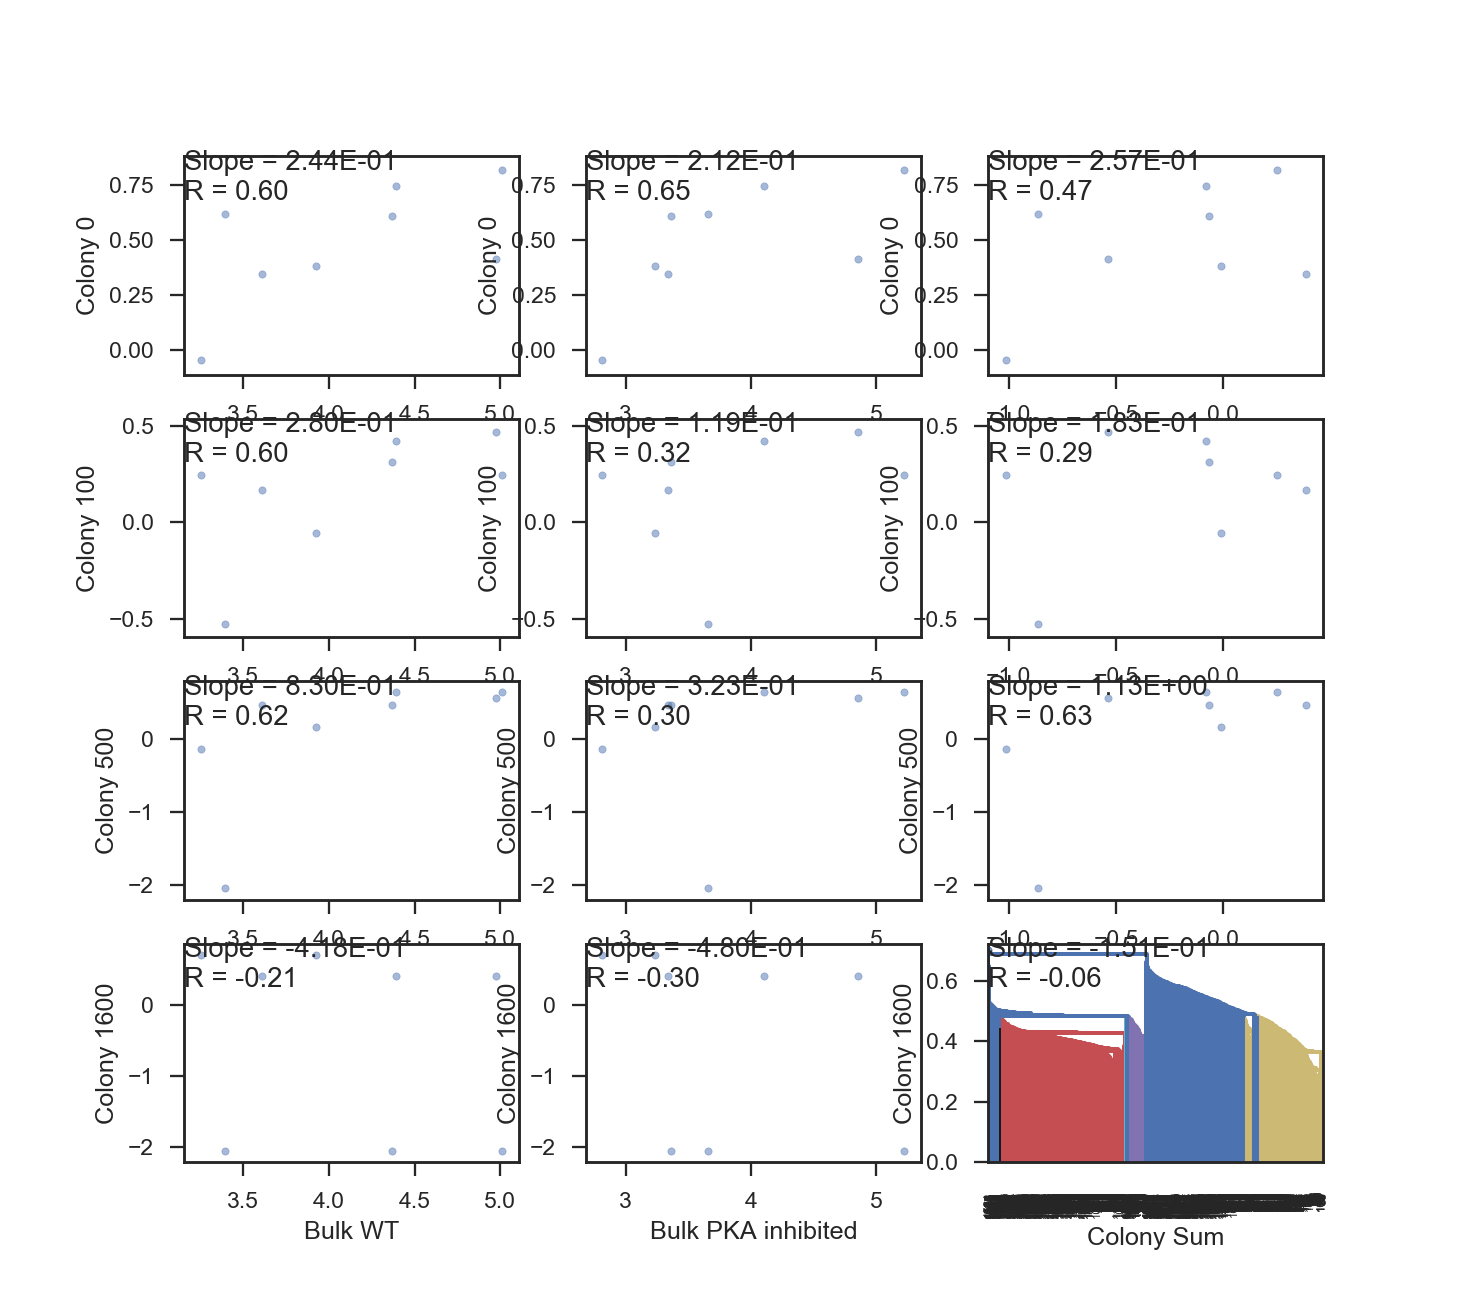

In [46]:
#just look at moclo genes
fig, axarr = plt.subplots(4,3, sharey = False)
#,

columndata_x_dict = {'Bulk WT': ARO4_high_exp_genes_norm_log10_merged.loc[moclo_genes_above_thresh,'AS_noNMPP1_YPD_t40_mean'],
                     'Bulk PKA inhibited': ARO4_high_exp_genes_norm_log10_merged.loc[moclo_genes_above_thresh,'AS_yesNMPP1_YPD_t40_mean'], 
                     'Colony Sum': ARO4_high_exp_genes_norm_log10_avg[moclo_genes_above_thresh]}

for kk, x_name in enumerate(columndata_x_dict.keys()):
    
    columndata_x = columndata_x_dict[x_name]  
    for jj, ncol in enumerate([0,100,500,1600]):
        ax = axarr[jj,kk]
        column_y = ARO4_high_exp_genes_norm_log10_merged.columns[ncol]
        columndata_y = ARO4_high_exp_genes_norm_log10_merged.loc[moclo_genes_above_thresh,column_y]
        ax.scatter(columndata_x, columndata_y, s = 10, alpha=0.5)
        slope, intercept, r_value, p_value, std_err = stats.linregress(columndata_x,columndata_y)
        ax.set_ylabel("Colony " + str(ncol))
        ax.text(0,0.8, "Slope = {:.2E}\nR = {:.2f}".format(slope, r_value),transform=ax.transAxes)
        if jj==3:
            ax.set_xlabel(x_name)
    

In [153]:
#Make a matrix for heirarchical clustering and PCA
ARO4_mat = ARO4_high_exp_genes_norm_log10.values

In [48]:
#Heirarchical cluster genes (using log normalized values)

#row_cluster
#ARO4_mat = ARO4_high_exp_genes_norm_log10.values
row_cluster = sch.linkage(ARO4_mat, method='average')
row_ind_reorder = sch.leaves_list(row_cluster)

old_rows = ARO4_high_exp_genes_norm_log10.index.tolist()
new_rows = [old_rows[ind] for ind in row_ind_reorder]

ARO4_high_exp_genes_norm_log10_reorder =ARO4_high_exp_genes_norm_log10.reindex(new_rows)

col_cluster = sch.linkage(ARO4_mat.transpose(), method='average', metric = 'correlation')
col_dend = sch.dendrogram(col_cluster)
col_ind_reorder = col_dend['leaves']

old_cols = ARO4_high_exp_genes_norm_log10.columns.tolist()
new_cols = [old_cols[ind] for ind in col_ind_reorder]

ARO4_high_exp_genes_norm_log10_reorder =ARO4_high_exp_genes_norm_log10_reorder[new_cols]




<IPython.core.display.Javascript object>


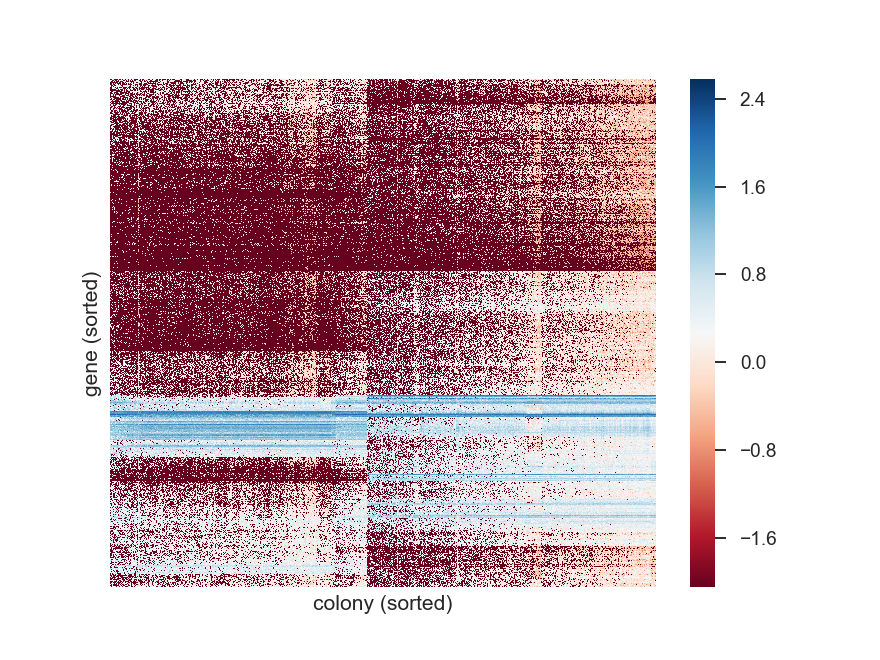

In [11]:
fig, ax = plt.subplots()
#ax = plt.imshow(ARO4_high_exp_genes_norm_reorder.values, interpolation="nearest", aspect = 'auto', cmap = 'RdBu',vmin=0, vmax = 5)
sns.heatmap(ARO4_high_exp_genes_norm_log10_reorder,cmap = 'RdBu', xticklabels=False, yticklabels=False)
ax.set_xlabel("colony (sorted)")
ax.set_ylabel("gene (sorted)")



[ 0.20213336  0.04721118  0.01030553]
[ 575.13160081  277.9525465   129.86236901]


<IPython.core.display.Javascript object>


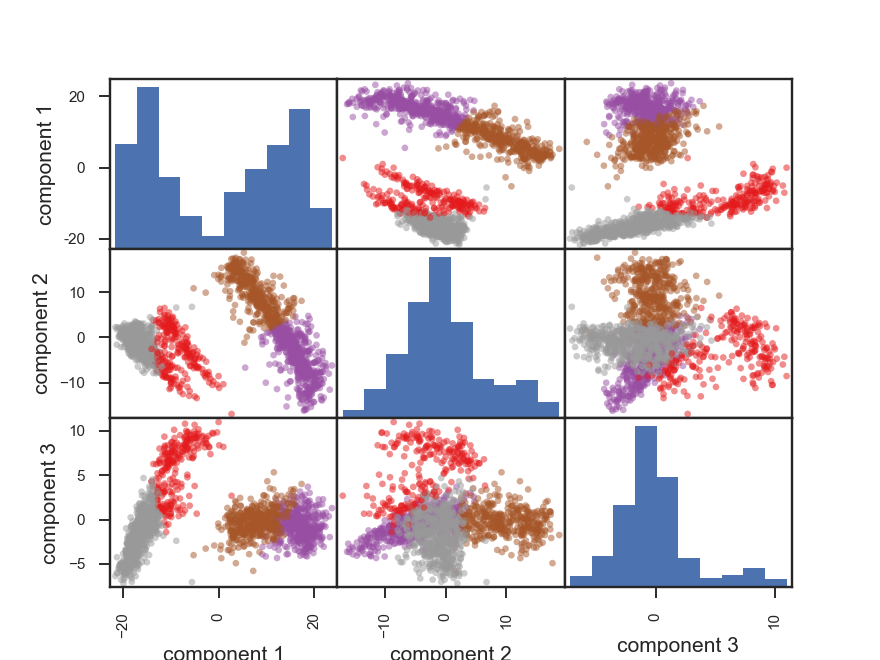

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000025707DF01D0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000002570A4AFF60>]], dtype=object)

In [154]:
#PCA Analysis

#ARO4_mat = ARO4_high_exp_genes_norm_log10.values
pca = PCA(n_components=3)
pca.fit(ARO4_mat.transpose())
print(pca.explained_variance_ratio_)  
print(pca.singular_values_)  
ARO4_high_exp_genes_PCA = pca.fit_transform(ARO4_mat.transpose())
ARO4_high_exp_genes_PCA_df = pd.DataFrame(ARO4_high_exp_genes_PCA.transpose(), index = ["component 1", "component 2", "component 3"], columns = ARO4_high_exp_genes.columns )
kmeans = KMeans(n_clusters=4).fit(ARO4_high_exp_genes_PCA_df.transpose().values)
pd.plotting.scatter_matrix(ARO4_high_exp_genes_PCA_df.transpose(), c = kmeans.labels_, cmap = "Set1")


In [548]:
#Print out genes with 30 highest and 30 lowest coefficients from principle components. 
N_top_genes = 30
component_genes = {}
for component in [0,1,2]:
    print("Principal component " + str(component+1))
    for sign in ['negative','positive']: 
        if sign=='positive': 
            genes = pd.Series(pca.components_[component], index = ARO4_high_exp_genes_norm.index).sort_values()[-N_top_genes:].sort_values(ascending=False)
        elif sign=='negative': 
            genes = pd.Series(pca.components_[component], index = ARO4_high_exp_genes_norm.index).sort_values()[0:N_top_genes].sort_values(ascending=True)
        print('genes with largest magnitude' + sign + 'coefficients')
        component_genes['PC{} {} genes'.format(component+1, sign)] = list(genes.index)
        component_genes['PC{} {} values'.format(component+1, sign)] = list(genes.values)
        for item, value in genes.iteritems():
            print("{} \t {:.3f}".format(item, value))

component_genes_df = pd.DataFrame(component_genes)
component_genes_df.to_csv(data_processing_dir + os.sep + 'top_positive_negative_pc_genes_raw.csv')

Principal component 1
genes with largest magnitudenegativecoefficients
TMA10 	 -0.327
HSP12 	 -0.283
STF2 	 -0.237
YNR034W-A 	 -0.224
HOR7 	 -0.202
21S_rRNA 	 -0.171
YDR034W-B 	 -0.136
SPG4 	 -0.123
RGI1 	 -0.099
YER121W 	 -0.087
PMP3 	 -0.068
YBR085C-A 	 -0.061
SPG1 	 -0.060
YHR138C 	 -0.059
CUP1-2 	 -0.053
CYC7 	 -0.052
CUP1-1 	 -0.052
AIM41 	 -0.051
FMP43 	 -0.045
RDL1 	 -0.044
QCR8 	 -0.043
TRX2 	 -0.039
SOD1 	 -0.037
GLC8 	 -0.037
RGI2 	 -0.037
CRS5 	 -0.036
YLR257W 	 -0.033
HMRA1 	 -0.033
YOR052C 	 -0.032
YKL065W-A 	 -0.031
genes with largest magnitudepositivecoefficients
RPL41A 	 0.268
RPL23B 	 0.235
RPL29 	 0.217
RPS30A 	 0.211
RPS10A 	 0.203
RPL26B 	 0.162
RPS17A 	 0.140
RPS31 	 0.122
RPL24A 	 0.119
YFR032C-B 	 0.118
RPL43B 	 0.108
RPS23A 	 0.108
RPS10B 	 0.096
RPL35A 	 0.091
RPL38 	 0.085
RPS18A 	 0.080
RPS21A 	 0.079
RPL34B 	 0.078
RPS17B 	 0.077
RPL35B 	 0.076
RPL42B 	 0.075
RPS30B 	 0.074
RPL40A 	 0.069
RPS27B 	 0.068
RPS12 	 0.066
RPS18B 	 0.063
RPL24B 	 0.063
RPS23B 	 0.

In [155]:
#projection into Linear combination of PC space 

##rename vsep and vhet

#choose new origin (x is for PC1 , y is for PC2, xp and yp are for new axes)
x0 = 3.1
y0 = -1.6

#choose point that determines direction for xp
x_xp = 20.9
y_xp = 10.5

#find point that determines direction for yp (ensure it is orthogonal to direction xp)
x_yp = -6.9
y_yp = y0 - (x_xp-x0)*(x_yp-x0)/(y_xp-y0)

xp = np.array([x_xp-x0, y_xp-y0])
yp = np.array([x_yp-x0, y_yp-y0])

xp_unit = xp/np.linalg.norm(xp)
yp_unit = yp/np.linalg.norm(yp)




In [86]:
transformed_genes = {'Xp': xp_unit[0]*pca.components_[0] + xp_unit[1]*pca.components_[1], 
                     'Yp': yp_unit[0]*pca.components_[0] + yp_unit[1]*pca.components_[1]}


N_top_genes = 30
component_genes = {}
for direction, transformed_gene_set in transformed_genes.items():
    print(direction + " genespace")
    for sign in ['negative','positive']: 
        if sign=='positive': 
            genes = pd.Series(transformed_gene_set, index = ARO4_high_exp_genes_norm_log10.index).sort_values()[-N_top_genes:].sort_values(ascending=False)
        elif sign=='negative': 
            genes = pd.Series(transformed_gene_set, index = ARO4_high_exp_genes_norm_log10.index).sort_values()[0:N_top_genes].sort_values(ascending=True)
        #print('genes with largest magnitude' + sign + 'coefficients')
        print('{} {} genes'.format(direction, sign))
        component_genes['{} {} genes'.format(direction, sign)] = list(genes.index)
        component_genes['{} {} values'.format(direction, sign)] = list(genes.values)
#         for item, value in genes.iteritems():
#             print("{} \t {:.3f}".format(item, value))

component_genes_df = pd.DataFrame(component_genes)
component_genes_df.to_csv(data_processing_dir + os.sep + 'top_positive_negative_log_transformed_genes_raw.csv')

Xp genespace
Xp negative genes
Xp positive genes
Yp genespace
Yp negative genes
Yp positive genes


<IPython.core.display.Javascript object>


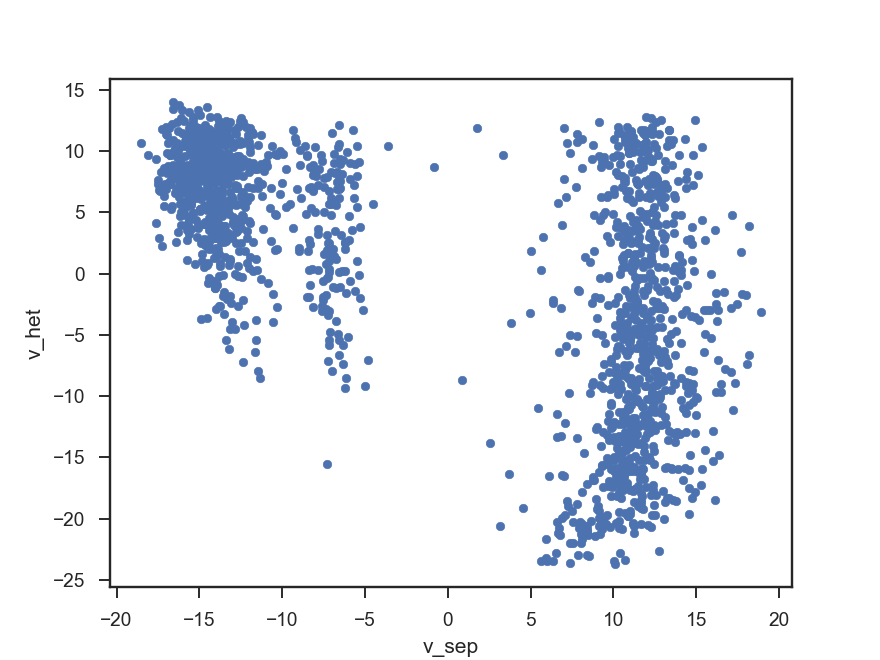

In [156]:
fig, ax = plt.subplots()
ARO4_data_xpyp = np.array([xp_unit, yp_unit]).dot(ARO4_high_exp_genes_PCA_df.loc[['component 1', 'component 2'], :].values)
ARO4_data_xpyp_df = pd.DataFrame(ARO4_data_xpyp, index = ['v_sep','v_het'], columns = ARO4_high_exp_genes_PCA_df.columns)
ARO4_data_xpyp_df.transpose().plot(x='v_sep',y='v_het', kind='scatter',ax=ax)
ax.set_xlabel = "v_sep"
ax.set_ylabel = "v_het"
#ax.scatter(ARO4_data_xpyp[0],ARO4_high_exp_genes_log10_PCA_df.loc[['component 3'], :].values)
            

In [157]:
v_sep_cutoff_1_2 = -9.83
v_sep_cutoff_2_3 = 0.0
cluster_A = ARO4_data_xpyp_df.loc[:,ARO4_data_xpyp_df.loc['v_sep',:]<v_sep_cutoff_1_2].columns
cluster_B = ARO4_data_xpyp_df.loc[:, (ARO4_data_xpyp_df.loc['v_sep',:]>v_sep_cutoff_1_2) & 
                                  (ARO4_data_xpyp_df.loc['v_sep',:]<v_sep_cutoff_2_3)].columns
cluster_C = ARO4_data_xpyp_df.loc[:,ARO4_data_xpyp_df.loc['v_sep',:]>v_sep_cutoff_2_3].columns

Cluster A 620 colonies
Cluster B 155 colonies
Cluster C 867 colonies

<IPython.core.display.Javascript object>


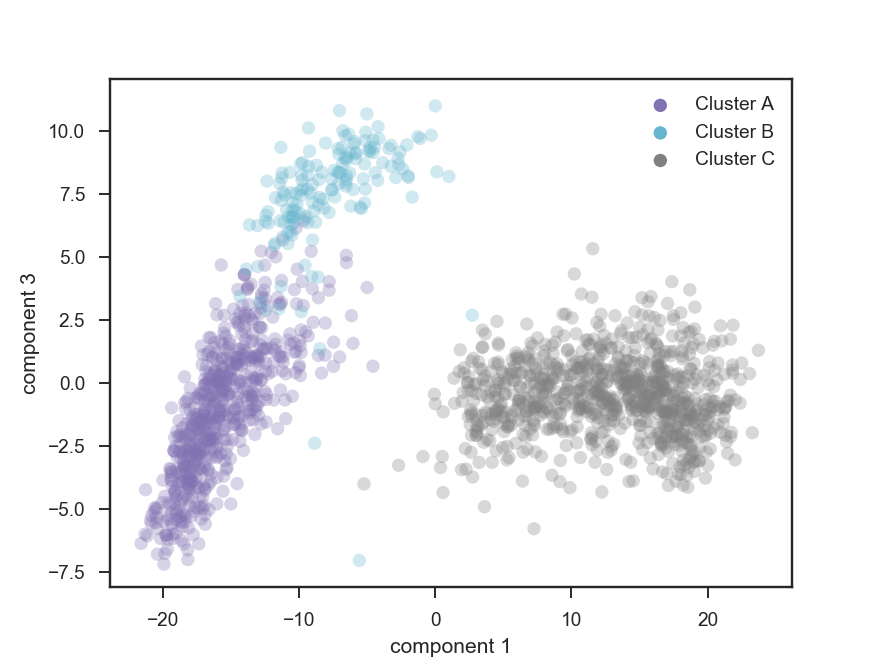

In [160]:
fig, ax = plt.subplots()

#Add labels, fix alpha on legend
x_component = 'component 1'
y_component = 'component 3'

clusters = {'Cluster A': cluster_A, 'Cluster B':cluster_B, 'Cluster C':cluster_C}
colors = {'Cluster A': 'm', 'Cluster B': 'c', 'Cluster C': 'gray'}
for name, cluster in clusters.items():
    color = colors[name]
    x_values = ARO4_high_exp_genes_PCA_df.loc[x_component, cluster]
    y_values = ARO4_high_exp_genes_PCA_df.loc[y_component, cluster]
    ax.scatter(x_values, y_values, c=color, label=name,
               alpha=0.3, edgecolors='none')

ax.set_xlabel(x_component)
ax.set_ylabel(y_component)
leg = ax.legend()
for lh in leg.legendHandles:
    lh.set_alpha(1)

<IPython.core.display.Javascript object>


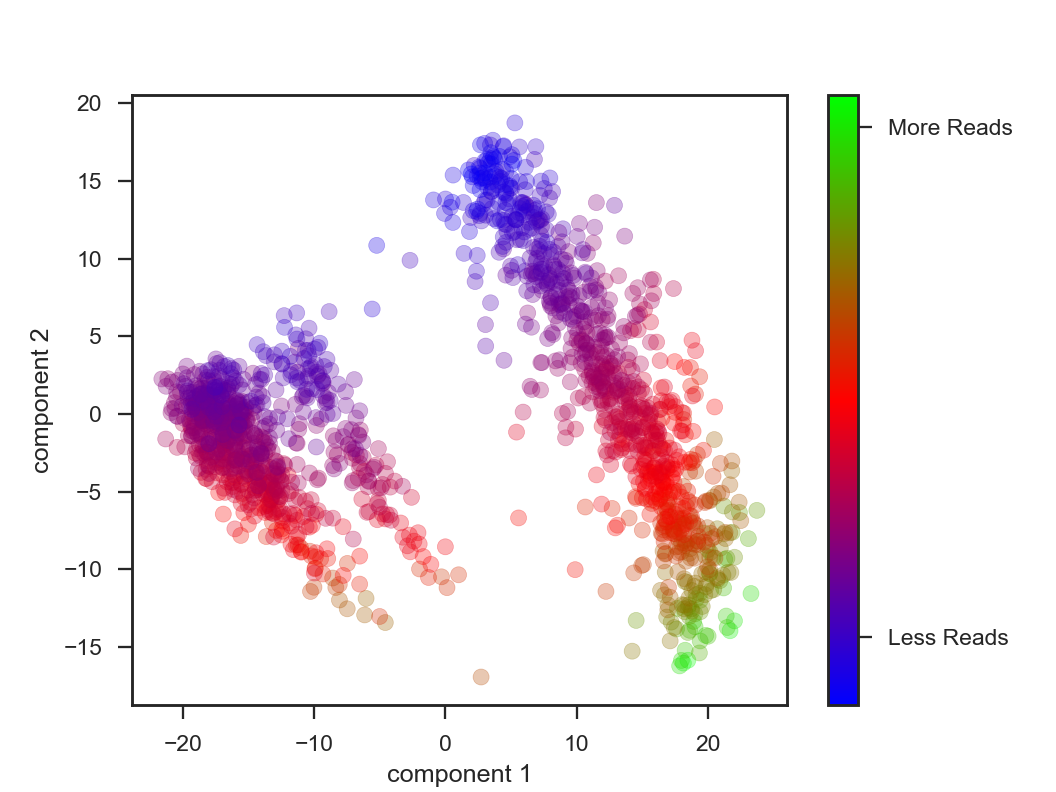

In [208]:
fig, ax = plt.subplots()

#Add labels, fix alpha on legend
x_component = 'component 1'
y_component = 'component 2'

x_values = ARO4_high_exp_genes_PCA_df.loc[x_component, :]
y_values = ARO4_high_exp_genes_PCA_df.loc[y_component, :]
#clusters = {'Cluster 1': cluster_1, 'Cluster 2':cluster_2, 'Cluster 3':cluster_3}
#colors = {'Cluster 1': 'red', 'Cluster 2': 'green', 'Cluster 3': 'blue'}
scatter = ax.scatter(x_values, y_values, c=np.log(ARO4_high_exp_genes.sum()), cmap = "brg",
               alpha=0.3)

ax.set_xlabel(x_component)
ax.set_ylabel(y_component)

cbar = fig.colorbar(scatter, ax=ax, ticks = [10.0, 7.0], alpha=None)
cbar.set_alpha(1.0)
cbar.draw_all()
cbar.ax.set_yticklabels(['More Reads', 'Less Reads'])  # vertically oriented colorbar

In [208]:
cluster_A_avg_sort = ARO4_high_exp_genes_norm_log10.loc[:,cluster_A].mean(axis=1).sort_values(ascending=False).index
ARO4_high_exp_genes_norm_log10_sort_by_cluster_A =ARO4_high_exp_genes_norm_log10.reindex(cluster_A_avg_sort)
diff_cluster_C_A = (ARO4_high_exp_genes_norm_log10_sort_by_cluster_A.loc[:,cluster_C].mean(axis=1)-ARO4_high_exp_genes_norm_log10_sort_by_cluster_A.loc[:,cluster_A].mean(axis=1))
diff_cluster_B_A = (ARO4_high_exp_genes_norm_log10_sort_by_cluster_A.loc[:,cluster_B].mean(axis=1)-ARO4_high_exp_genes_norm_log10_sort_by_cluster_A.loc[:,cluster_A].mean(axis=1))
enriched_cluster_A_vs_C = list(diff_cluster_C_A[diff_cluster_C_A<-1].index)
enriched_cluster_C_vs_A = list(diff_cluster_C_A[diff_cluster_C_A>1].index)
enriched_cluster_B_vs_A = list(diff_cluster_B_A[diff_cluster_B_A>0.5].index)
enriched_cluster_A_vs_B = list(diff_cluster_B_A[diff_cluster_B_A<-0.5].index)
enriched_cluster_B_vs_A_not_C_vs_A = list(set(enriched_cluster_B_vs_A)-set(enriched_cluster_C_vs_A))
enriched_cluster_A_vs_B_not_A_vs_C = list(set(enriched_cluster_A_vs_B)-set(enriched_cluster_A_vs_C))

In [221]:
diff_cluster_C_A.sort_values(ascending=False)[0:30].values

array([ 3.38548853,  3.13257637,  3.11841235,  2.86015784,  2.85083147,
        2.63627821,  2.62629024,  2.57608048,  2.5737882 ,  2.53831072,
        2.46169279,  2.44548041,  2.42023914,  2.36718532,  2.35936869,
        2.23460289,  2.22314046,  2.12697823,  2.07149279,  2.01850977,
        2.01281899,  1.99274364,  1.97034619,  1.96942199,  1.96660196,
        1.95721037,  1.93515355,  1.90726461,  1.90071903,  1.89682732])

In [225]:
#print out enrichment
N_top_genes = 100

cluster_diffs = {'C_minus_A': diff_cluster_C_A, 'B_minus_A': diff_cluster_B_A}
cluster_diff_genes = {}
for cluster_diff_name, cluster_diff in cluster_diffs.items():
    print(cluster_diff_name)
    for sign in ['negative','positive']: 
        if sign=='positive': 
            genes = cluster_diff.sort_values(ascending=False)[0:N_top_genes]
        elif sign=='negative': 
            genes = cluster_diff.sort_values()[0:N_top_genes]
        #print('genes with largest magnitude' + sign + 'coefficients')
        print('{} {} genes'.format(cluster_diff_name, sign))
        cluster_diff_genes['{} {} genes'.format(cluster_diff_name, sign)] = list(genes.index)
        cluster_diff_genes['{} {} values'.format(cluster_diff_name, sign)] = list(genes.values)
#         for item, value in genes.iteritems():
#             print("{} \t {:.3f}".format(item, value))

cluster_diff_genes_df = pd.DataFrame(cluster_diff_genes)
cluster_diff_genes_df.to_csv(data_processing_dir + os.sep + 'top_positive_negative_cluster_difference_genes.csv')

C_minus_A
C_minus_A negative genes
C_minus_A positive genes
B_minus_A
B_minus_A negative genes
B_minus_A positive genes


<IPython.core.display.Javascript object>


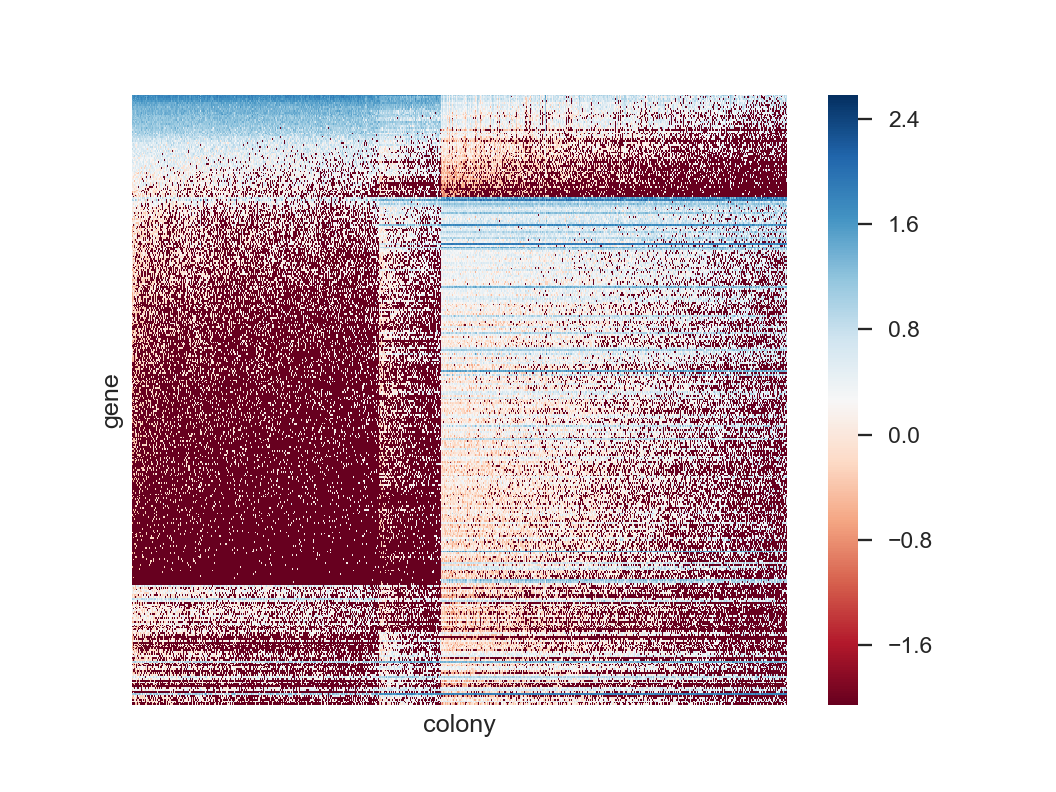

In [212]:
fig, ax = plt.subplots()
ARO4_cluster_reorder = ARO4_high_exp_genes_norm_log10.loc[enriched_cluster_1_vs_3 + enriched_cluster_3_vs_1 + enriched_cluster_1_vs_2_not_1_vs_3 + enriched_cluster_2_vs_1_not_3_vs_1,list(cluster_1) + list(cluster_2) + list(cluster_3)]
#ax = plt.imshow(ARO4_high_exp_genes_norm_reorder.values, interpolation="nearest", aspect = 'auto', cmap = 'RdBu',vmin=0, vmax = 5)
sns.heatmap(ARO4_cluster_reorder,cmap = 'RdBu', xticklabels=False, yticklabels=False)
ax.set_xlabel("colony")
ax.set_ylabel("gene")

<IPython.core.display.Javascript object>


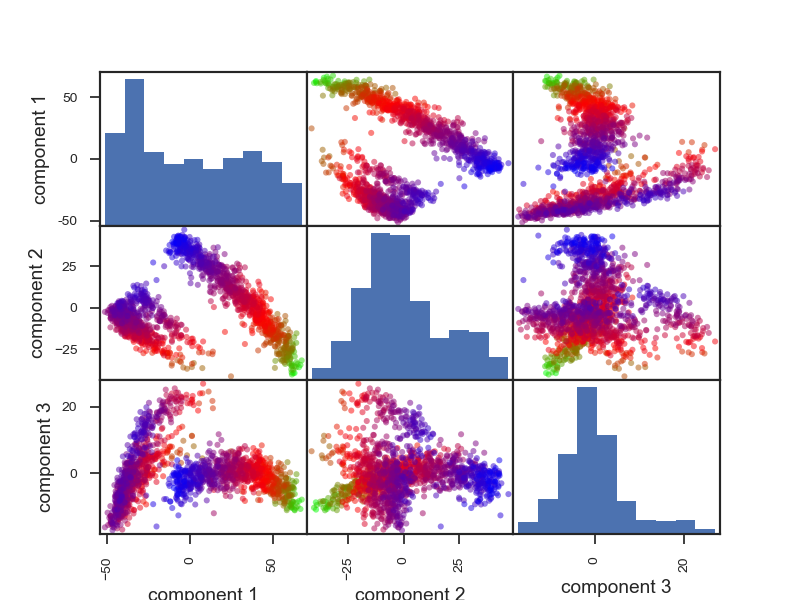

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C759DC0B00>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001C75A5A2DD8>]], dtype=object)

In [67]:
pd.plotting.scatter_matrix(ARO4_high_exp_genes_log10_PCA_df.transpose(), c = np.log(ARO4_high_exp_genes.sum()), cmap = "brg")

<IPython.core.display.Javascript object>


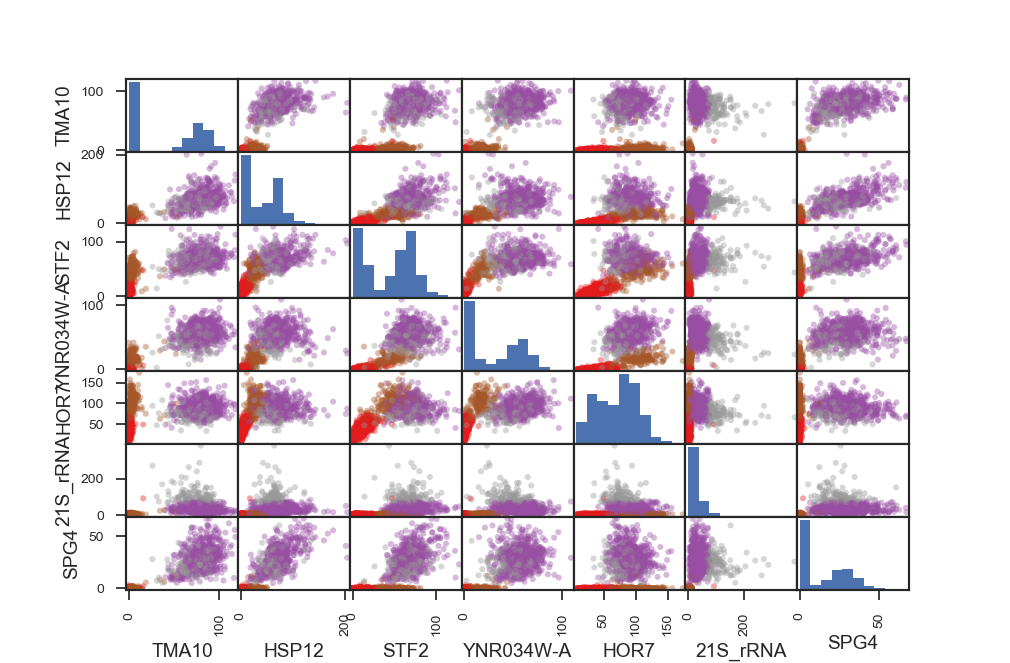

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021C5900A4E0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000021C27C35DA0>]], dtype=object)

In [560]:
# fix, ax = plt.subplots()
# x = ARO4_high_exp_genes_norm_reorder.loc['LYS12',:]
# y = ARO4_high_exp_genes_norm_reorder.loc['LEU1',:]
# ax.scatter(x,y, alpha = 0.2)
gene_list = ['TMA10','HSP12','STF2','YNR034W-A','HOR7','21S_rRNA','SPG4'] #['GLN1','SER3','LYS12','MET14','LEU1'] #['AI4', '15S_rRNA','AIM13'] #'21S_rRNA','ABF2','ADE12','ACT1','AHP1',
#['RPL41A','RPL23B','RPL29','RPS30A','RPS10A']
#['OLI1', 'FMP43', 'RGI2', 'YDR119W-A']
#['SPG4', 'SPG1']
#['VAM10', 'VAM7', 'VAM8'] these aren't highly expressed enough
#['GLN1','SER3','LYS12','MET14','LEU1'] these ones are,
pd.plotting.scatter_matrix(ARO4_high_exp_genes_norm.loc[gene_list, :].transpose(), c = kmeans.labels_, cmap = "Set1", alpha = 0.4)

